In [88]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [89]:
DATA_GOLD = Path("../data/gold")

df = pd.read_parquet(DATA_GOLD / "train_features.parquet")

df.shape

(1017209, 33)

In [90]:
X = df.drop("Sales", axis=1)
y = df["Sales"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((813767, 32), (203442, 32))

In [91]:
# Target / features
X = df.drop("Sales", axis=1).copy()
y = df["Sales"].copy()

# Date -> numeric features e drop Date
if "Date" in X.columns:
    X["Year"] = X["Date"].dt.year.astype("int16")
    X["Month"] = X["Date"].dt.month.astype("int8")
    X["Day"] = X["Date"].dt.day.astype("int8")
    X["WeekOfYear"] = X["Date"].dt.isocalendar().week.astype("int16")
    X["DayOfWeek_fromDate"] = X["Date"].dt.dayofweek.astype("int8")
    X = X.drop(columns=["Date"])

# One-hot encode de TODAS as colunas object (strings)
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Object cols:", obj_cols)

X = pd.get_dummies(X, columns=obj_cols, drop_first=True)

# Garantir que tudo seja numérico (segurança)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

# Garantia final: tudo numérico
print("Non-numeric after dummies:", X.select_dtypes(exclude=["number"]).columns.tolist())

Object cols: ['PromoInterval']
Non-numeric after dummies: ['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec']


In [92]:
# Remover coluna que causa leakage
if "Customers" in X.columns:
    X = X.drop(columns=["Customers"])

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [94]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_test, y_pred)

mae, rmse

(482.00382885539847, 832.3339631979205)

In [95]:
import pandas as pd

fi = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

fi.head(20)

Open                         0.459827
Store                        0.084736
CompetitionDistance          0.055473
CompetitionDistanceLog       0.054500
HasPromo                     0.041146
CompetitionOpenSinceYear     0.040323
CompetitionOpenSinceMonth    0.034812
Promo                        0.032315
DayOfYear                    0.025392
Promo2SinceYear              0.020692
Day                          0.019745
DayOfWeek_fromDate           0.017256
DayOfWeek                    0.017123
Promo2SinceWeek              0.014728
StoreType_b                  0.014428
Assortment_c                 0.013695
StoreType_c                  0.008460
Year                         0.008073
StoreType_d                  0.007435
WeekOfYear                   0.005432
dtype: float64

<Axes: >

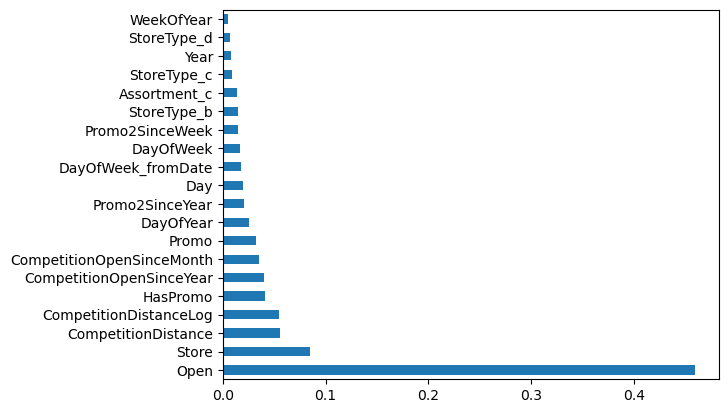

In [96]:
fi.head(20).plot(kind="barh")